In [1]:
from __init__ import PRP; import sys
sys.path.append(PRP + 'veros/')

from datetime import datetime
from jax import config
config.update("jax_enable_x64", True)

In [2]:

sys.path.append(PRP)

from scripts.grad_compare import *
from scripts.utils import *

from setups.acc.acc_learning import ACCSetup
from tqdm import tqdm
import gc 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn

from jax import lax

/Users/emeunier/Desktop/Projets/Veros-Autodiff/
Differentiable Veros Experimental version
Importing core modules
 Using computational backend jax on cpu
  Kernels are compiled during first iteration, be patient
 Runtime settings are now locked



# Spin-up

In [3]:
# Spin-up 
warmup_steps = 200
acc = ACCSetup()
acc.setup()


def ps(state) : 
    n_state = state.copy()
    acc.step(n_state)
    return n_state

# Spin-up 
acc = ACCSetup()
acc.setup()

step_jit = jax.jit(ps)

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075
Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


100%|██████████| 200/200 [00:08<00:00, 24.32it/s]


Backward vjp - Directional Gradients

# Methods

### Setup Comparison

In [4]:
var_dev = 'temp'
random = 'normal'

direction = jnp.zeros_like(getattr(state.variables, var_dev))
if random == 'normal' :
    direction = jax.random.normal(jax.random.PRNGKey(0), direction.shape)
elif random == 'uniform' :
    direction = jax.random.uniform(jax.random.PRNGKey(0), direction.shape)
elif random == 'ones' :
    direction = jnp.ones_like(direction)


direction = direction / jnp.linalg.norm(direction)

In [5]:
state = state.copy()
field = getattr(state.variables, var_dev)

In [6]:
var_agg = 'temp'
def agg_sum(state, key_sum = 'temp') :
    tau = getattr(state.variables, 'tau')
    return ((getattr(state.variables, key_sum))**2).sum()
    
agg_function = lambda state : agg_sum(state, key_sum=var_agg)

1. VJP Recursive 

In [7]:
vjpm = vjp_grad(acc.step, agg_function, var_dev)

vjpm.step_function = jax.jit(vjpm.step_function)
vjpm.agg_function = jax.jit(vjpm.agg_function)

loss_and_grad = lambda s, v, it: vjpm.g(s, v, iterations=it)

In [8]:
def dir_der_autodiff(state, field, direction, loss_and_grad, iterations) :
    output_forward, gradients = loss_and_grad(state, field, it=iterations)
    analytical_dir_deriv = jnp.sum(gradients * direction)
    return output_forward, analytical_dir_deriv

In [9]:
%%time

dir_der_autodiff(state, field, direction, loss_and_grad, iterations=3)

CPU times: user 1min 16s, sys: 2.21 s, total: 1min 19s
Wall time: 1min 19s


(Array(6180577.0211651, dtype=float64), Array(-13.73019202, dtype=float64))

In [16]:
%%time

dir_der_autodiff(state, field, direction, loss_and_grad, iterations=3)

CPU times: user 1.09 s, sys: 292 ms, total: 1.38 s
Wall time: 1.22 s


(Array(6180577.0211651, dtype=float64), Array(-13.73019202, dtype=float64))

1. ter : loop storing the states

In [11]:
class vjp_grad_gpu_loop(autodiff):
    def g(self, state, var_value, iterations=1, **kwargs):
        n_state = autodiff.set_var(self.var_name, state, var_value)

        # --- Forward pass: store states ---
        states = [n_state]
        current_state = n_state
        for _ in range(iterations):
            current_state = self.step_function(current_state)
            states.append(current_state)

        # --- Aggregation ---
        l, vjp_agg = jax.vjp(self.agg_function, current_state)
        ds, = vjp_agg(jnp.ones_like(l))

        # --- Backward pass (reverse loop over states) ---
        for state in reversed(states[:-1]):
            _, vjp_fun = jax.vjp(self.step_function, state)
            ds, = vjp_fun(ds)

        grad = attrgetter(f'variables.{self.var_name}')(ds)
        return l, grad

In [12]:
vjpm_t = vjp_grad_gpu_loop(acc.step, agg_function, var_dev)

vjpm_t.step_function = jax.jit(vjpm_t.step_function)
vjpm_t.agg_function = jax.jit(vjpm_t.agg_function)

loss_and_grad_t = lambda s, v, it: vjpm_t.g(s, v, iterations=it)

In [13]:
%%time
dir_der_autodiff(state, field, direction, loss_and_grad_t, iterations=3)

CPU times: user 1min 17s, sys: 2.43 s, total: 1min 20s
Wall time: 1min 20s


(Array(6180577.02120129, dtype=float64), Array(-13.73019279, dtype=float64))

In [17]:
%%time
dir_der_autodiff(state, field, direction, loss_and_grad_t, iterations=3)

CPU times: user 1.11 s, sys: 170 ms, total: 1.28 s
Wall time: 1.1 s


(Array(6180577.02120129, dtype=float64), Array(-13.73019279, dtype=float64))

2. VJP New

In [18]:
vjpm_n = vjp_grad_new(acc.step, agg_function, var_dev)

vjpm_n.step_function = jax.jit(vjpm_n.step_function)
vjpm_n.agg_function = jax.jit(vjpm_n.agg_function)

loss_and_grad_n = lambda s, v, it: vjpm_n.g(s, v, iterations=it)

In [19]:
%%time
dir_der_autodiff(state, field, direction, loss_and_grad_n, iterations=3)

CPU times: user 1min 16s, sys: 2.29 s, total: 1min 18s
Wall time: 1min 19s


(Array(6180577.02120129, dtype=float64), Array(-13.73019279, dtype=float64))

In [20]:
%%time
dir_der_autodiff(state, field, direction, loss_and_grad_n, iterations=3)

CPU times: user 10.6 s, sys: 418 ms, total: 11.1 s
Wall time: 10.9 s


(Array(6180577.02120129, dtype=float64), Array(-13.73019279, dtype=float64))

2bis. VJP New + Remat

In [21]:
vjpm_nr = vjp_grad_new(acc.step, agg_function, var_dev)

vjpm_nr.step_function = jax.jit(vjpm_nr.step_function)
vjpm_nr.agg_function = jax.jit(vjpm_nr.agg_function)

vjpm_nr.step_function = jax.checkpoint(vjpm_nr.step_function) # Remat to save memory


loss_and_grad_nr = lambda s, v, it: vjpm_nr.g(s, v, iterations=it)

In [22]:
%%time
dir_der_autodiff(state, field, direction, loss_and_grad_nr, iterations=3)

CPU times: user 1min 29s, sys: 2.49 s, total: 1min 31s
Wall time: 1min 31s


(Array(6180577.02120129, dtype=float64), Array(-13.73019279, dtype=float64))

In [24]:
%%time
dir_der_autodiff(state, field, direction, loss_and_grad_nr, iterations=3)

CPU times: user 315 ms, sys: 183 ms, total: 498 ms
Wall time: 403 ms


(Array(6180577.02120129, dtype=float64), Array(-13.73019279, dtype=float64))

3. Numerical Diff

In [40]:
class numerical_diff_tensor(autodiff) :

    @staticmethod
    def perturb(field, direction, epsilon= 1e-4) : 
        field_pert = field.copy() + epsilon * direction
        return field_pert

    def g(self, state, var_value, direction, iterations=1, epsilon=1e-9, **kwargs) :

        forward = partial(autodiff.wrapper,
                        state=state,
                        step_fun=self.step_function,
                        var_name=self.var_name,
                        agg_func=self.agg_function,
                        iter=iterations)

        field_plus = self.perturb(var_value, direction, epsilon)
        f_plus = forward(field_plus)
        
        field_minus = self.perturb(var_value, -direction, epsilon)
        f_minus = forward(field_minus)
        
        numerical_dir_deriv = (f_plus - f_minus) / (2 * epsilon)

        return (f_plus + f_minus)/2, numerical_dir_deriv

In [41]:
# Numerical directional derivative check for the full tensor

ndm = numerical_diff_tensor(acc.step, agg_function, var_dev)

ndm.step_function = jax.jit(ndm.step_function)
ndm.agg_function = jax.jit(ndm.agg_function)

In [42]:
%%time
ndm.g(state, field, direction, iterations=3, epsilon=1e-9)

CPU times: user 13.8 s, sys: 235 ms, total: 14 s
Wall time: 11.9 s


(Array(6180577.08618217, dtype=float64), Array(-13.96983862, dtype=float64))

# Precision vs. iteration

In [85]:
stats = []

for nitt in range(100) :
    s = {'n_iteration' : nitt, 'device' : field.device.device_kind}
    s['autodiff_loss'], s['autodiff_grad'] = dir_der_autodiff(state, field, direction, loss_and_grad, iterations=nitt)
    
    s['numerical_loss'], s['numerical_grad'] = ndm.g(state, field, direction, iterations=nitt, epsilon=1e-4)
    stats.append(s)
    print(s)

{'n_iteration': 0, 'device': 'cpu', 'autodiff_loss': Array(6184714.32963765, dtype=float64), 'autodiff_grad': Array(-10.44907478, dtype=float64), 'numerical_loss': Array(6184714.32963767, dtype=float64), 'numerical_grad': Array(-10.44917852, dtype=float64)}
{'n_iteration': 1, 'device': 'cpu', 'autodiff_loss': Array(6183304.63660689, dtype=float64), 'autodiff_grad': Array(-0.81549404, dtype=float64), 'numerical_loss': Array(6183304.63660692, dtype=float64), 'numerical_grad': Array(-0.81567559, dtype=float64)}
{'n_iteration': 2, 'device': 'cpu', 'autodiff_loss': Array(6181931.29426615, dtype=float64), 'autodiff_grad': Array(-12.49582405, dtype=float64), 'numerical_loss': Array(6181931.29427488, dtype=float64), 'numerical_grad': Array(-12.48237211, dtype=float64)}
{'n_iteration': 3, 'device': 'cpu', 'autodiff_loss': Array(6180577.09823968, dtype=float64), 'autodiff_grad': Array(-13.69720604, dtype=float64), 'numerical_loss': Array(6180577.09827205, dtype=float64), 'numerical_grad': Array(


KeyboardInterrupt



In [89]:
stats = pd.DataFrame(stats)

In [93]:
stats = stats.pivot(columns='variable', index='n_iteration', values='value').reset_index()

In [95]:
stats.drop(columns=['variable'])

KeyError: "['variable'] not found in axis"

In [98]:
stats.melt(id_vars=['n_iteration', 'device'])

,n_iteration,device,variable,value
0,0,cpu,autodiff_grad,-10.449074779107422
1,1,cpu,autodiff_grad,-0.815494035146556
2,2,cpu,autodiff_grad,-12.495824045775215
3,3,cpu,autodiff_grad,-13.69720604313649
4,4,cpu,autodiff_grad,-12.726444486418249
...,...,...,...,...
119,26,cpu,numerical_loss,6148977.770973782
120,27,cpu,numerical_loss,6147613.908665667
121,28,cpu,numerical_loss,6146253.535574829
122,29,cpu,numerical_loss,6144897.781621482


In [100]:
statsdf = pd.DataFrame(stats)
statsdf['accuracy'] = 1 - np.abs((statsdf['autodiff_grad'] - statsdf['numerical_grad'])/statsdf['numerical_grad'])
statsdf = statsdf.melt(id_vars=['n_iteration', 'device'])
statsdf['value'] = statsdf['value'].apply(lambda x : x.item())

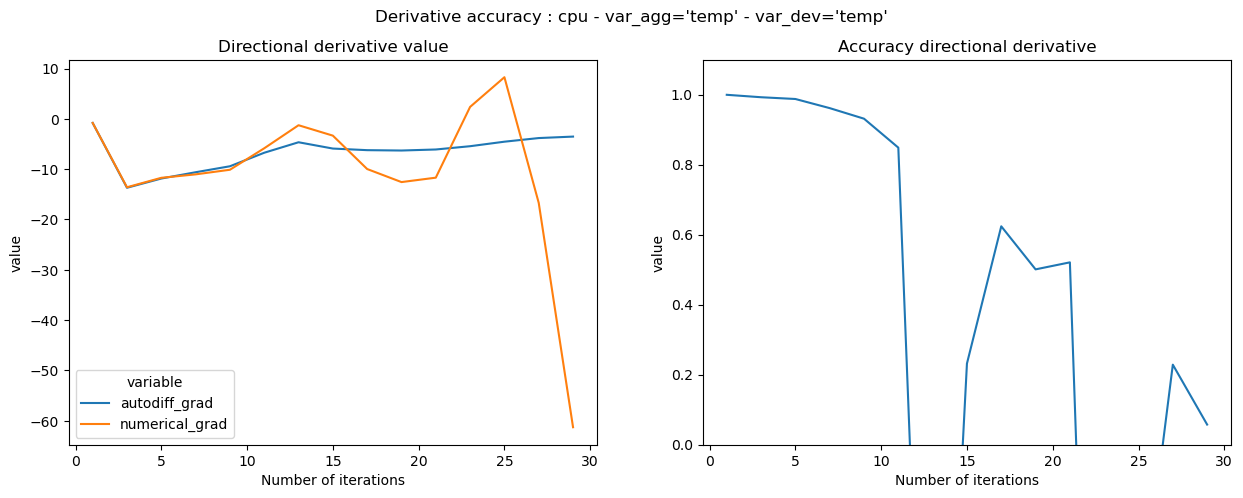

In [111]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(data=statsdf.query('n_iteration and variable != "accuracy" and variable.str.contains("grad")', engine='python'),
             x='n_iteration', y='value', hue='variable', ax=axs[0])
axs[0].set_title('Directional derivative value')
axs[0].set_xlabel('Number of iterations')
sns.lineplot(data=statsdf.query('n_iteration and variable == "accuracy"'),
             x='n_iteration', y='value', ax=axs[1])
axs[1].set_title('Accuracy directional derivative')
axs[1].set_ylim([0,1.1])
axs[1].set_xlabel('Number of iterations')
fig.suptitle(f'Derivative accuracy : {field.device.device_kind} - {var_agg=} - {var_dev=}')
fig.savefig(f'figures/directional_derivative_accuracy_{field.device.device_kind}_{datetime.now().strftime("%d%m%y")}.png')

In [ ]:
w